In [35]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ast import literal_eval
%matplotlib inline

In [36]:
# Get data
array_files_csv = glob.glob("Circles/*_circle.csv")

In [37]:
array_files_csv

['Circles/smal_circle.csv', 'Circles/big_circle.csv']

In [38]:
def concatenateDatasets(array_to_concatenate):
    dataset = 0
    array = []
    for velocidadeVia in array_to_concatenate:
        dataset = pd.read_csv(velocidadeVia,sep='\t')
        array.append(dataset)
    return pd.concat(array)

In [39]:
#Create an array with all data arrays
dataFiles = concatenateDatasets(array_files_csv)

In [40]:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)

In [41]:
# Create unique array with data
dataFiles = dataFiles.drop('Unnamed: 0', axis=1)

In [42]:
dim = input("Digite o valor da dimensão ")

Digite o valor da dimensão 2


In [43]:
dim = int(dim)

In [46]:
k_value = input("Insira o tamanho do Dicionario (K): ")

Insira o tamanho do Dicionario (K): 32


In [47]:
k_value = int(k_value)

In [48]:
limiar_dist = input("Insira o Limiar de distorção: ")

Insira o Limiar de distorção: 0.00000001


In [49]:
limiar_dist = float(limiar_dist)

In [50]:
## K means initialization
import random
import re
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

r = 1
s = 0

centroidsIniciais=[]
centroidsFinal=[]
numero_iteracoes=[]
mse=[]
starter_cent = []

with open("Circles/inicialCentroids_32centroids.txt", "rb") as fp:   # Unpickling
    starter_cent = pickle.load(fp)

while r <= 30:
    k = k_value

    centroids = starter_cent[s]
    import pandas as pd

    df = pd.DataFrame(columns=[])
    df = dataFiles
    df = df.rename(columns={'x':'0','y':'1'})

    def assignment(df, centroids):
        for i in centroids.keys():
            value = 0
            # (x1 - x2)² + (y1 - y2)²
            for a in range(dim):
                value = (df[f"{a}"] - centroids[i][a]) ** 2 + value
            df['distance_from_{}'.format(i)] = value
        centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
        df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
        df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
#         df['color'] = df['closest'].map(lambda x: colors[x])
        return df

    df = assignment(df, centroids)

    import copy

    old_centroids = copy.deepcopy(centroids)

    def update(current):
        new_k = copy.deepcopy(centroids)
        k = k_value
        for j in current.keys():
            for l in range(dim):
                #centroids = old_value + 1.8 * (current_value - old_value)
                current[j][l] = np.mean(df[df['closest'] == j][f"{l}"])
                new_k[j][l] = old_centroids[j][l] + 0.7 * (current[j][l] - old_centroids[j][l])
                # normal k[i][a] = np.mean(df[df['closest'] == i][a])
        return new_k


    centroids = update(centroids)

    df = assignment(df, centroids)
    
    a = 0
    while True:
        a = a + 1
        closest_centroids = df['closest'].copy(deep=True)
        for i in closest_centroids:
            df['old_value'] = df['distance_from_{}'.format(i)]
        centroids = update(centroids)
        df = assignment(df, centroids)
        current_centroids = df['closest'].copy(deep=True)
        for i in current_centroids:
            df['current_value'] = df['distance_from_{}'.format(i)]
        delta = (np.sum(df['old_value']) - np.sum(df['current_value']))/(np.sum(df['old_value']))
        if delta <= limiar_dist: 
            break
    num_int = a        

    old_df = df
    old_df = old_df.drop(['0','1','closest','old_value','current_value'], axis=1)
    for i in centroids.keys():
        old_df = old_df.rename(columns={f"distance_from_{i}":f"{i}"})    
    new_df = pd.DataFrame(columns=['new_data_with_centroids'])
    def reconstrucao():
        arr = []
        valueCentroidMin = old_df.idxmin(axis=1)
        valueCentroidMin = np.array(valueCentroidMin)
        for i in valueCentroidMin:
            arr.append(centroids[int(i)])
        new_df['new_data_with_centroids'] = arr

    reconstrucao()

    new_df['old_data_x'] = dataFiles['x'].to_numpy()
    new_df['old_data_y'] = dataFiles['y'].to_numpy()

    array_x = []
    array_y = []
    for i in new_df['new_data_with_centroids']:
        array_x.append(i[0])
        array_y.append(i[1])
    new_df['x_new'] = array_x
    new_df['y_new'] = array_y
    new_df = new_df.drop(['new_data_with_centroids'], axis=1)

    # new_df

    a = 0
    MSE = 0
    new_value = [*new_df['x_new'].to_numpy() , *new_df['y_new'].to_numpy()] 
    old_value = [*new_df['old_data_x'].to_numpy() , *new_df['old_data_y'].to_numpy()]
    for i in new_value:
        MSE = (i - old_value[a]) **2 + MSE  
        a = a + 1
    MSE = MSE / len(new_value) 
    dataFrameFinal = pd.DataFrame(columns=[])

    centroidsFinal.append(json.dumps(centroids))
    numero_iteracoes.append(num_int)
    mse.append(MSE)

    r = r + 1
    s = s + 1

dataFrameFinal['MSE'] = mse
dataFrameFinal['centroidsInicial'] = starter_cent
dataFrameFinal['centroidsFinal'] = centroidsFinal
dataFrameFinal['NInteracoes'] = numero_iteracoes

dataFrameFinal.to_csv('Circles/tables/tabela_final_Kmeans_Acelerado_32centroids.csv')

In [51]:
value_test = json.loads(dataFrameFinal['centroidsFinal'][29])

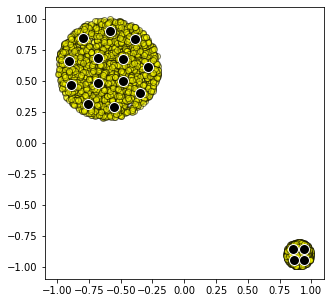

In [52]:
fig = plt.figure(figsize=(5,5))
img = plt.scatter(df['0'], df['1'],color='yellow',alpha=0.5,edgecolor='k')
for i in value_test.keys():
    plt.scatter(*value_test[i],color='black',s=100,edgecolor='white')
plt.show()